## Random Forest importance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

## Read Data

In [2]:
data = pd.read_csv('../UNSW_Train.csv')
data.shape

(175341, 44)

In [3]:
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack,is_intrusion
0,0.121478,113.0,0.0,2.0,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,0,0
1,0.649902,113.0,0.0,2.0,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,0,0
2,1.623129,113.0,0.0,2.0,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,0,0
3,1.681642,113.0,3.0,2.0,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,0,0
4,0.449454,113.0,0.0,2.0,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,0,0


### Train - Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((140272, 43), (35069, 43))

### Select features with tree importance

In [5]:
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=10))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=10))

In [6]:
sel_.get_support()

array([False, False, False, False, False, False, False, False,  True,
        True, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True])

In [7]:
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

7

In [8]:
selected_feat

Index(['rate', 'sttl', 'dload', 'sinpkt', 'dmean', 'ct_state_ttl', 'attack'], dtype='object')

### Plot importances

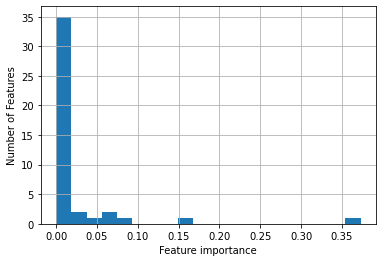

In [9]:
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [10]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 43
selected features: 7
features with importance greater than the mean importance of all features: 7


In [11]:
selected_feat

Index(['rate', 'sttl', 'dload', 'sinpkt', 'dmean', 'ct_state_ttl', 'attack'], dtype='object')

In [12]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

In [13]:
X_train.shape, X_test.shape

((140272, 7), (35069, 7))

## Standardize Data




In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers





In [15]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation



In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression




In [17]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25).fit(X_train, y_train)

CPU times: user 71.6 ms, sys: 176 ms, total: 248 ms
Wall time: 1.89 s


In [18]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.7334397901280333
F1 Score: 0.7651728295819935
FPR: 0.06713498132669393
TPR: 0.6392981572430004


### Naive Bayes




In [19]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-08).fit(X_train, y_train)

CPU times: user 29.8 ms, sys: 10.3 ms, total: 40 ms
Wall time: 38.1 ms


In [20]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.7450454817645213
F1 Score: 0.7790436179414308
FPR: 0.07825004446025254
TPR: 0.6616295176929857


### Random Forest






In [21]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000).fit(X_train, y_train)

CPU times: user 36.5 s, sys: 1.18 s, total: 37.7 s
Wall time: 37.7 s


In [22]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


### KNN




In [23]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform').fit(X_train, y_train)

CPU times: user 8.34 s, sys: 36.9 ms, total: 8.37 s
Wall time: 8.34 s


In [24]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.7287918104308648
f1: 0.7586346910290573
fpr: 0.056464520718477684
tpr: 0.627418880913403


### CatBoost




In [25]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6539664	total: 63.1ms	remaining: 3.09s
1:	learn: 0.6177900	total: 70.2ms	remaining: 1.68s
2:	learn: 0.5843566	total: 79.4ms	remaining: 1.24s
3:	learn: 0.5533191	total: 88.7ms	remaining: 1.02s
4:	learn: 0.5244111	total: 97.3ms	remaining: 876ms
5:	learn: 0.4973864	total: 103ms	remaining: 756ms
6:	learn: 0.4722014	total: 112ms	remaining: 685ms
7:	learn: 0.4485945	total: 120ms	remaining: 632ms
8:	learn: 0.4264578	total: 130ms	remaining: 594ms
9:	learn: 0.4056154	total: 138ms	remaining: 550ms
10:	learn: 0.3860267	total: 146ms	remaining: 516ms
11:	learn: 0.3675945	total: 157ms	remaining: 496ms
12:	learn: 0.3502164	total: 165ms	remaining: 470ms
13:	learn: 0.3338012	total: 174ms	remaining: 446ms
14:	learn: 0.3182918	total: 182ms	remaining: 425ms
15:	learn: 0.3036042	total: 188ms	remaining: 399ms
16:	learn: 0.2897062	total: 194ms	remaining: 377ms
17:	learn: 0.2765591	total: 203ms	remaining: 361ms
18:	learn: 0.2640797	total: 210ms	remaining: 342ms
19:	learn: 0.2522629	total: 219ms	re

In [26]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


## Model Evaluation





In [27]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../UNSW_Test.csv")
test_df.shape

(175341, 44)

In [28]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion'])

In [29]:
X_eval = X_eval[selected_feat]

In [30]:
X_eval.shape

(175341, 7)

### Model Evaluation - Logistic Regression




In [32]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25)
modelLR.fit(X_train, y_train)

LogisticRegression(C=25, n_jobs=-1, random_state=42)

In [33]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [34]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  1.0
Testing accuracy is  0.7334397901280333


In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.7334397901280333
F1 Score: 0.7651728295819935
Precision Score: 0.9527682202064436
Recall Score: 0.6392981572430004
Confusion Matrix:
 [[10491   755]
 [ 8593 15230]]


### Cross validation - Logistic Regression




In [36]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.86210 (+/- 0.15696)
F1 Score: 0.90962 (+/- 0.08974)
Precision: 0.84590 (+/- 0.15325)
Recall: 0.98876 (+/- 0.01216)


### Model Evaluation - Naive Bayes





In [37]:
modelNB = GaussianNB(var_smoothing=1e-08)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

In [38]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [39]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  1.0
Testing accuracy is  0.7450454817645213


In [40]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.7450454817645213
F1 Score: 0.7790436179414308
Precision Score: 0.9471217401754597
Recall Score: 0.6616295176929857
Confusion Matrix:
 [[10366   880]
 [ 8061 15762]]


### Cross validation - Naive Bayes





In [41]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.84025 (+/- 0.13030)
F1 Score: 0.89462 (+/- 0.07232)
Precision: 0.82776 (+/- 0.12827)
Recall: 0.97733 (+/- 0.02265)


### Model Evaluation - Random Forest




In [42]:
modelRF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=0)

In [43]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [44]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.6793179161082438


In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - Random Forest





In [46]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
F1 Score: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)


### Model Evaluation - KNN



In [47]:
modelKNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1)

In [48]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [49]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9999928709934983
Testing accuracy is  0.7287918104308648


In [50]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.7287918104308648
F1 Score: 0.7586346910290573
Precision Score: 0.9592478500834296
Recall Score: 0.627418880913403
Confusion Matrix:
 [[10611   635]
 [ 8876 14947]]


### Cross validation - KNN






In [51]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.90906 (+/- 0.09588)
F1 Score: 0.93617 (+/- 0.05945)
Precision: 0.92016 (+/- 0.13654)
Recall: 0.95739 (+/- 0.05278)


### Model Evaluation - CatBoost





In [52]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6539664	total: 6.34ms	remaining: 311ms
1:	learn: 0.6177900	total: 12.4ms	remaining: 298ms
2:	learn: 0.5843566	total: 20.5ms	remaining: 321ms
3:	learn: 0.5533191	total: 28.8ms	remaining: 331ms
4:	learn: 0.5244111	total: 37.5ms	remaining: 338ms
5:	learn: 0.4973864	total: 43.5ms	remaining: 319ms
6:	learn: 0.4722014	total: 51.6ms	remaining: 317ms
7:	learn: 0.4485945	total: 60.1ms	remaining: 315ms
8:	learn: 0.4264578	total: 68.1ms	remaining: 310ms
9:	learn: 0.4056154	total: 73.4ms	remaining: 294ms
10:	learn: 0.3860267	total: 80.1ms	remaining: 284ms
11:	learn: 0.3675945	total: 88.8ms	remaining: 281ms
12:	learn: 0.3502164	total: 97.4ms	remaining: 277ms
13:	learn: 0.3338012	total: 106ms	remaining: 272ms
14:	learn: 0.3182918	total: 115ms	remaining: 268ms
15:	learn: 0.3036042	total: 121ms	remaining: 257ms
16:	learn: 0.2897062	total: 127ms	remaining: 246ms
17:	learn: 0.2765591	total: 135ms	remaining: 240ms
18:	learn: 0.2640797	total: 143ms	remaining: 233ms
19:	learn: 0.2522629	total: 

In [53]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [54]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  1.0
Testing accuracy is  0.6793179161082438


In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - CatBoost





In [56]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6539643	total: 6.55ms	remaining: 321ms
1:	learn: 0.6177867	total: 13.4ms	remaining: 323ms
2:	learn: 0.5843451	total: 22.7ms	remaining: 355ms
3:	learn: 0.5532990	total: 32.9ms	remaining: 378ms
4:	learn: 0.5243848	total: 41.3ms	remaining: 372ms
5:	learn: 0.4973614	total: 47.1ms	remaining: 345ms
6:	learn: 0.4721689	total: 55.9ms	remaining: 343ms
7:	learn: 0.4485597	total: 65.4ms	remaining: 343ms
8:	learn: 0.4264196	total: 75ms	remaining: 341ms
9:	learn: 0.4055786	total: 81.6ms	remaining: 327ms
10:	learn: 0.3859898	total: 89.1ms	remaining: 316ms
11:	learn: 0.3675558	total: 99ms	remaining: 314ms
12:	learn: 0.3501739	total: 108ms	remaining: 308ms
13:	learn: 0.3337574	total: 117ms	remaining: 301ms
14:	learn: 0.3182480	total: 126ms	remaining: 293ms
15:	learn: 0.3035621	total: 132ms	remaining: 280ms
16:	learn: 0.2896652	total: 138ms	remaining: 268ms
17:	learn: 0.2765177	total: 147ms	remaining: 260ms
18:	learn: 0.2640393	total: 154ms	remaining: 252ms
19:	learn: 0.2522216	total: 163ms

13:	learn: 0.3337631	total: 115ms	remaining: 296ms
14:	learn: 0.3182486	total: 124ms	remaining: 290ms
15:	learn: 0.3035627	total: 131ms	remaining: 278ms
16:	learn: 0.2896658	total: 137ms	remaining: 267ms
17:	learn: 0.2765184	total: 147ms	remaining: 261ms
18:	learn: 0.2640398	total: 156ms	remaining: 254ms
19:	learn: 0.2522222	total: 166ms	remaining: 249ms
20:	learn: 0.2410048	total: 175ms	remaining: 242ms
21:	learn: 0.2303243	total: 181ms	remaining: 231ms
22:	learn: 0.2202157	total: 190ms	remaining: 224ms
23:	learn: 0.2105615	total: 198ms	remaining: 214ms
24:	learn: 0.2013894	total: 207ms	remaining: 207ms
25:	learn: 0.1926591	total: 216ms	remaining: 199ms
26:	learn: 0.1843470	total: 226ms	remaining: 192ms
27:	learn: 0.1764183	total: 233ms	remaining: 183ms
28:	learn: 0.1688617	total: 239ms	remaining: 173ms
29:	learn: 0.1616684	total: 248ms	remaining: 166ms
30:	learn: 0.1548181	total: 258ms	remaining: 158ms
31:	learn: 0.1482777	total: 268ms	remaining: 151ms
32:	learn: 0.1420127	total: 274

37:	learn: 0.1147576	total: 327ms	remaining: 103ms
38:	learn: 0.1099939	total: 336ms	remaining: 94.7ms
39:	learn: 0.1054522	total: 344ms	remaining: 86ms
40:	learn: 0.1010952	total: 350ms	remaining: 76.9ms
41:	learn: 0.0969514	total: 359ms	remaining: 68.5ms
42:	learn: 0.0929614	total: 365ms	remaining: 59.4ms
43:	learn: 0.0891451	total: 372ms	remaining: 50.7ms
44:	learn: 0.0854974	total: 379ms	remaining: 42.1ms
45:	learn: 0.0820282	total: 389ms	remaining: 33.8ms
46:	learn: 0.0786855	total: 397ms	remaining: 25.4ms
47:	learn: 0.0754985	total: 407ms	remaining: 17ms
48:	learn: 0.0724304	total: 414ms	remaining: 8.46ms
49:	learn: 0.0694867	total: 420ms	remaining: 0us
0:	learn: 0.6539643	total: 6.89ms	remaining: 338ms
1:	learn: 0.6177866	total: 13ms	remaining: 311ms
2:	learn: 0.5843466	total: 21.5ms	remaining: 337ms
3:	learn: 0.5532998	total: 30.8ms	remaining: 354ms
4:	learn: 0.5243840	total: 40.3ms	remaining: 362ms
5:	learn: 0.4973606	total: 46.7ms	remaining: 342ms
6:	learn: 0.4721693	total: 5

48:	learn: 0.0724219	total: 400ms	remaining: 8.16ms
49:	learn: 0.0694786	total: 406ms	remaining: 0us
0:	learn: 0.6539643	total: 6.78ms	remaining: 332ms
1:	learn: 0.6177867	total: 12.9ms	remaining: 310ms
2:	learn: 0.5843451	total: 21.7ms	remaining: 341ms
3:	learn: 0.5532990	total: 32.1ms	remaining: 369ms
4:	learn: 0.5243848	total: 41.3ms	remaining: 372ms
5:	learn: 0.4973614	total: 47.3ms	remaining: 347ms
6:	learn: 0.4721689	total: 56ms	remaining: 344ms
7:	learn: 0.4485597	total: 64.9ms	remaining: 341ms
8:	learn: 0.4264196	total: 73.6ms	remaining: 335ms
9:	learn: 0.4055786	total: 80.4ms	remaining: 322ms
10:	learn: 0.3859898	total: 88.1ms	remaining: 312ms
11:	learn: 0.3675558	total: 96.8ms	remaining: 307ms
12:	learn: 0.3501739	total: 105ms	remaining: 300ms
13:	learn: 0.3337574	total: 116ms	remaining: 297ms
14:	learn: 0.3182480	total: 125ms	remaining: 293ms
15:	learn: 0.3035621	total: 132ms	remaining: 280ms
16:	learn: 0.2896652	total: 138ms	remaining: 269ms
17:	learn: 0.2765177	total: 148m

13:	learn: 0.3337631	total: 118ms	remaining: 304ms
14:	learn: 0.3182486	total: 128ms	remaining: 298ms
15:	learn: 0.3035627	total: 134ms	remaining: 286ms
16:	learn: 0.2896658	total: 142ms	remaining: 275ms
17:	learn: 0.2765184	total: 151ms	remaining: 268ms
18:	learn: 0.2640398	total: 159ms	remaining: 259ms
19:	learn: 0.2522222	total: 168ms	remaining: 252ms
20:	learn: 0.2410048	total: 177ms	remaining: 244ms
21:	learn: 0.2303243	total: 183ms	remaining: 233ms
22:	learn: 0.2202157	total: 194ms	remaining: 228ms
23:	learn: 0.2105615	total: 201ms	remaining: 217ms
24:	learn: 0.2013894	total: 209ms	remaining: 209ms
25:	learn: 0.1926591	total: 217ms	remaining: 201ms
26:	learn: 0.1843470	total: 226ms	remaining: 193ms
27:	learn: 0.1764183	total: 234ms	remaining: 184ms
28:	learn: 0.1688617	total: 241ms	remaining: 174ms
29:	learn: 0.1616684	total: 250ms	remaining: 167ms
30:	learn: 0.1548181	total: 260ms	remaining: 159ms
31:	learn: 0.1482777	total: 269ms	remaining: 151ms
32:	learn: 0.1420127	total: 275

24:	learn: 0.2013946	total: 209ms	remaining: 209ms
25:	learn: 0.1926642	total: 219ms	remaining: 202ms
26:	learn: 0.1843521	total: 229ms	remaining: 195ms
27:	learn: 0.1764232	total: 236ms	remaining: 185ms
28:	learn: 0.1688663	total: 242ms	remaining: 176ms
29:	learn: 0.1616738	total: 252ms	remaining: 168ms
30:	learn: 0.1548243	total: 261ms	remaining: 160ms
31:	learn: 0.1482839	total: 270ms	remaining: 152ms
32:	learn: 0.1420186	total: 276ms	remaining: 142ms
33:	learn: 0.1360529	total: 285ms	remaining: 134ms
34:	learn: 0.1303602	total: 295ms	remaining: 126ms
35:	learn: 0.1249027	total: 300ms	remaining: 117ms
36:	learn: 0.1197129	total: 310ms	remaining: 109ms
37:	learn: 0.1147576	total: 321ms	remaining: 102ms
38:	learn: 0.1099939	total: 328ms	remaining: 92.6ms
39:	learn: 0.1054522	total: 336ms	remaining: 84.1ms
40:	learn: 0.1010952	total: 343ms	remaining: 75.2ms
41:	learn: 0.0969514	total: 352ms	remaining: 67.1ms
42:	learn: 0.0929614	total: 358ms	remaining: 58.3ms
43:	learn: 0.0891451	total

37:	learn: 0.1147487	total: 318ms	remaining: 101ms
38:	learn: 0.1099853	total: 326ms	remaining: 91.8ms
39:	learn: 0.1054437	total: 334ms	remaining: 83.5ms
40:	learn: 0.1010870	total: 340ms	remaining: 74.7ms
41:	learn: 0.0969433	total: 349ms	remaining: 66.5ms
42:	learn: 0.0929536	total: 355ms	remaining: 57.8ms
43:	learn: 0.0891377	total: 362ms	remaining: 49.3ms
44:	learn: 0.0854896	total: 370ms	remaining: 41.1ms
45:	learn: 0.0820199	total: 379ms	remaining: 32.9ms
46:	learn: 0.0786773	total: 386ms	remaining: 24.6ms
47:	learn: 0.0754897	total: 396ms	remaining: 16.5ms
48:	learn: 0.0724219	total: 403ms	remaining: 8.23ms
49:	learn: 0.0694786	total: 409ms	remaining: 0us
0:	learn: 0.6539643	total: 6.68ms	remaining: 327ms
1:	learn: 0.6177867	total: 14ms	remaining: 337ms
2:	learn: 0.5843451	total: 23.2ms	remaining: 364ms
3:	learn: 0.5532990	total: 33.1ms	remaining: 380ms
4:	learn: 0.5243848	total: 42.4ms	remaining: 382ms
5:	learn: 0.4973614	total: 48.1ms	remaining: 353ms
6:	learn: 0.4721689	tota

48:	learn: 0.0723976	total: 404ms	remaining: 8.25ms
49:	learn: 0.0694710	total: 414ms	remaining: 0us
0:	learn: 0.6539643	total: 6.93ms	remaining: 339ms
1:	learn: 0.6177867	total: 13.1ms	remaining: 314ms
2:	learn: 0.5843464	total: 21.5ms	remaining: 337ms
3:	learn: 0.5532995	total: 30.7ms	remaining: 353ms
4:	learn: 0.5243862	total: 39.5ms	remaining: 356ms
5:	learn: 0.4973627	total: 45.8ms	remaining: 336ms
6:	learn: 0.4721714	total: 54.9ms	remaining: 337ms
7:	learn: 0.4485626	total: 63.9ms	remaining: 335ms
8:	learn: 0.4264226	total: 74.1ms	remaining: 337ms
9:	learn: 0.4055815	total: 80ms	remaining: 320ms
10:	learn: 0.3859924	total: 87.5ms	remaining: 310ms
11:	learn: 0.3675583	total: 96.3ms	remaining: 305ms
12:	learn: 0.3501785	total: 105ms	remaining: 299ms
13:	learn: 0.3337631	total: 115ms	remaining: 294ms
14:	learn: 0.3182486	total: 124ms	remaining: 289ms
15:	learn: 0.3035627	total: 131ms	remaining: 278ms
16:	learn: 0.2896658	total: 138ms	remaining: 269ms
17:	learn: 0.2765184	total: 148m

13:	learn: 0.3337672	total: 119ms	remaining: 307ms
14:	learn: 0.3182572	total: 128ms	remaining: 299ms
15:	learn: 0.3035708	total: 135ms	remaining: 286ms
16:	learn: 0.2896735	total: 142ms	remaining: 275ms
17:	learn: 0.2765255	total: 151ms	remaining: 268ms
18:	learn: 0.2640466	total: 159ms	remaining: 259ms
19:	learn: 0.2522289	total: 168ms	remaining: 251ms
20:	learn: 0.2410108	total: 177ms	remaining: 244ms
21:	learn: 0.2303300	total: 183ms	remaining: 233ms
22:	learn: 0.2202214	total: 192ms	remaining: 225ms
23:	learn: 0.2105669	total: 198ms	remaining: 214ms
24:	learn: 0.2013946	total: 208ms	remaining: 208ms
25:	learn: 0.1926642	total: 216ms	remaining: 199ms
26:	learn: 0.1843521	total: 225ms	remaining: 192ms
27:	learn: 0.1764232	total: 233ms	remaining: 183ms
28:	learn: 0.1688663	total: 241ms	remaining: 174ms
29:	learn: 0.1616738	total: 250ms	remaining: 167ms
30:	learn: 0.1548243	total: 260ms	remaining: 159ms
31:	learn: 0.1482839	total: 269ms	remaining: 151ms
32:	learn: 0.1420186	total: 275

26:	learn: 0.1843467	total: 234ms	remaining: 200ms
27:	learn: 0.1764180	total: 242ms	remaining: 190ms
28:	learn: 0.1688614	total: 249ms	remaining: 180ms
29:	learn: 0.1616688	total: 258ms	remaining: 172ms
30:	learn: 0.1548166	total: 269ms	remaining: 165ms
31:	learn: 0.1482762	total: 278ms	remaining: 156ms
32:	learn: 0.1420112	total: 283ms	remaining: 146ms
33:	learn: 0.1360443	total: 292ms	remaining: 138ms
34:	learn: 0.1303505	total: 303ms	remaining: 130ms
35:	learn: 0.1248933	total: 309ms	remaining: 120ms
36:	learn: 0.1197040	total: 318ms	remaining: 112ms
37:	learn: 0.1147487	total: 328ms	remaining: 104ms
38:	learn: 0.1099853	total: 335ms	remaining: 94.5ms
39:	learn: 0.1054437	total: 345ms	remaining: 86.2ms
40:	learn: 0.1010870	total: 352ms	remaining: 77.3ms
41:	learn: 0.0969433	total: 362ms	remaining: 68.9ms
42:	learn: 0.0929536	total: 368ms	remaining: 59.9ms
43:	learn: 0.0891377	total: 375ms	remaining: 51.1ms
44:	learn: 0.0854896	total: 382ms	remaining: 42.5ms
45:	learn: 0.0820199	tot

0:	learn: 0.6539643	total: 6.96ms	remaining: 341ms
1:	learn: 0.6177867	total: 13.3ms	remaining: 319ms
2:	learn: 0.5843464	total: 21.9ms	remaining: 343ms
3:	learn: 0.5532995	total: 31ms	remaining: 357ms
4:	learn: 0.5243862	total: 40.9ms	remaining: 369ms
5:	learn: 0.4973627	total: 46.7ms	remaining: 342ms
6:	learn: 0.4721714	total: 55.5ms	remaining: 341ms
7:	learn: 0.4485626	total: 64.7ms	remaining: 340ms
8:	learn: 0.4264226	total: 73.5ms	remaining: 335ms
9:	learn: 0.4055815	total: 79.9ms	remaining: 320ms
10:	learn: 0.3859924	total: 87.5ms	remaining: 310ms
11:	learn: 0.3675583	total: 96.5ms	remaining: 306ms
12:	learn: 0.3501785	total: 105ms	remaining: 300ms
13:	learn: 0.3337631	total: 115ms	remaining: 296ms
14:	learn: 0.3182486	total: 125ms	remaining: 291ms
15:	learn: 0.3035627	total: 131ms	remaining: 279ms
16:	learn: 0.2896658	total: 138ms	remaining: 268ms
17:	learn: 0.2765184	total: 147ms	remaining: 261ms
18:	learn: 0.2640398	total: 155ms	remaining: 253ms
19:	learn: 0.2522222	total: 165

13:	learn: 0.3337672	total: 117ms	remaining: 301ms
14:	learn: 0.3182572	total: 127ms	remaining: 295ms
15:	learn: 0.3035708	total: 133ms	remaining: 283ms
16:	learn: 0.2896735	total: 140ms	remaining: 273ms
17:	learn: 0.2765255	total: 149ms	remaining: 266ms
18:	learn: 0.2640466	total: 157ms	remaining: 256ms
19:	learn: 0.2522289	total: 167ms	remaining: 250ms
20:	learn: 0.2410108	total: 176ms	remaining: 243ms
21:	learn: 0.2303300	total: 183ms	remaining: 233ms
22:	learn: 0.2202214	total: 192ms	remaining: 225ms
23:	learn: 0.2105669	total: 198ms	remaining: 215ms
24:	learn: 0.2013946	total: 207ms	remaining: 207ms
25:	learn: 0.1926642	total: 215ms	remaining: 199ms
26:	learn: 0.1843521	total: 224ms	remaining: 191ms
27:	learn: 0.1764232	total: 232ms	remaining: 182ms
28:	learn: 0.1688663	total: 239ms	remaining: 173ms
29:	learn: 0.1616738	total: 248ms	remaining: 165ms
30:	learn: 0.1548243	total: 258ms	remaining: 158ms
31:	learn: 0.1482839	total: 266ms	remaining: 150ms
32:	learn: 0.1420186	total: 272

38:	learn: 0.1099853	total: 321ms	remaining: 90.5ms
39:	learn: 0.1054437	total: 330ms	remaining: 82.5ms
40:	learn: 0.1010870	total: 336ms	remaining: 73.9ms
41:	learn: 0.0969433	total: 346ms	remaining: 65.9ms
42:	learn: 0.0929536	total: 352ms	remaining: 57.3ms
43:	learn: 0.0891377	total: 359ms	remaining: 48.9ms
44:	learn: 0.0854896	total: 367ms	remaining: 40.7ms
45:	learn: 0.0820199	total: 376ms	remaining: 32.7ms
46:	learn: 0.0786773	total: 383ms	remaining: 24.5ms
47:	learn: 0.0754897	total: 393ms	remaining: 16.4ms
48:	learn: 0.0724219	total: 400ms	remaining: 8.17ms
49:	learn: 0.0694786	total: 407ms	remaining: 0us


In [57]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
F1 Score: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
